<a href="_index.ipynb">&larr; WIN </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>
# DFT mit Rechteckfensterung
Im letzten Kapitel hatten wir uns mit der DFT beschäftigt von Vorgängen, die entweder vollständig in das Messfenster passen oder die sich fehlerfrei rekonstruieren lassen durch periodische Wiederholung des Signals im Messfenster
(gefenstertes Signal). In diesem Fall stimmt die DFT des abgetasteten, gefensterten Signals an den Frequenzpunkten mit dem Spektrum des zeitkontinuierlichen Signals überein.

Im Allgemeinen ist dies nicht möglich, weil man die Periode des Signals vorab nicht kennt oder Abtastfrequenz und / oder Anzahl der DFT-Punkte nicht frei wählbar sind. Dieses Notebook zeigt, dass die periodische Fortsetzung des gefensterten Signals im Zeitbereich dann nicht identisch mit dem ursprünglichen periodischen Signal ist und dementsprechend das Spektrum gegenüber dem des ursprünglichen Signals verfälscht ist.

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_lib as dsp # import and set plot properties
    
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from numpy import linspace, log10, cos, sin, pi
from numpy.fft import fft, fftshift, fftfreq
import scipy.signal as sig

figsize = {"figsize":(13,9)}

def stems(x, y, ax=None, label=None, s=20, **kwargs):
    """ A faster and more flexible replacement for stem plot"""
    bottom=kwargs.pop('bottom', 0) # pop the 'bottom' key-value pair from the dict (default: 0)
    ax.axhline(bottom, **kwargs)
    ax.vlines(x, y, bottom, **kwargs)
    ax.scatter(x,y, label=label, s=s, **kwargs)

Aus einer periodischen (unendlichen) Datenfolge $x[n]$ schneiden wir $N_{FFT}$ Datenpunkte im Zeitbereich aus und erhalten $x_w[n]$. Die DFT von $x_w[n]$ liefert uns $N_{FFT}$ Frequenzpunkte. **Wenn** die periodische Fortsetzung von $y_w[n]$ das ursprüngliche Signal $x[n]$ ergibt, d.h. wenn sich die $N_{FFT}$ Datenpunkte periodisch wiederholen, liefert die **DTFT** exakt das gleiche Ergebnis wie die DFT.

Die Länge des Messfensters $T_{mess} = T_S N_{FFT}$ und die Frequenzauflösung $\Delta f = f_S / N_{FFT} = 1 / T_{mess}$ ergeben sich automatisch aus Abtastfrequenz $f_S = 1/T_S$ und der Zahl der FFT-Punkte:

In [2]:
f_S = 1e5; T_S = 1./f_S  # Abtastfrequenz und -periode
N_FFT = 50               # Anzahl FFT Punkte
T_meas = T_S * N_FFT     # Dauer des Messfensters
Delta_f = f_S / N_FFT    # Frequenzauflösung
L = 3                    # Zeige L Messfenster 
OSR = 500                # "Oversampling Ratio" für Anzeige des pseudo-analogen Signals
 
t = linspace(0,T_meas*L, N_FFT * OSR*L, endpoint=False) # "analoge" Zeit über L Fenster
n = np.arange(0, N_FFT*L)                               # diskrete Zeitpunkte über L Fenster

print('T_meas = {0}s \t Delta f = {1} Hz'.format(T_meas, 1/T_meas))

T_meas = 0.0005s 	 Delta f = 2000.0 Hz


Wir erzeugen und plotten ein "analoges" Testsignal $x(t)$ mit zwei Tönen unterschiedlicher Frequenz $f_a$, $f_b$ und Amplitude $A_a$, $A_b$, einer überlagerten Gleichspannung sowie gaussverteiltem Rauschen mit Standardabweichung $\sigma$ (zunächst 0) über eine Gesamtzeitdauer von $L T_{meas}$ ($L$ Messfenster). Das abgetastete Signal $x[n]$ wird ebenfalls dargestellt. Das Messfenster ist grau hinterlegt:

f_a =  4400.0 Hz	 f_b =  18000.0 Hz


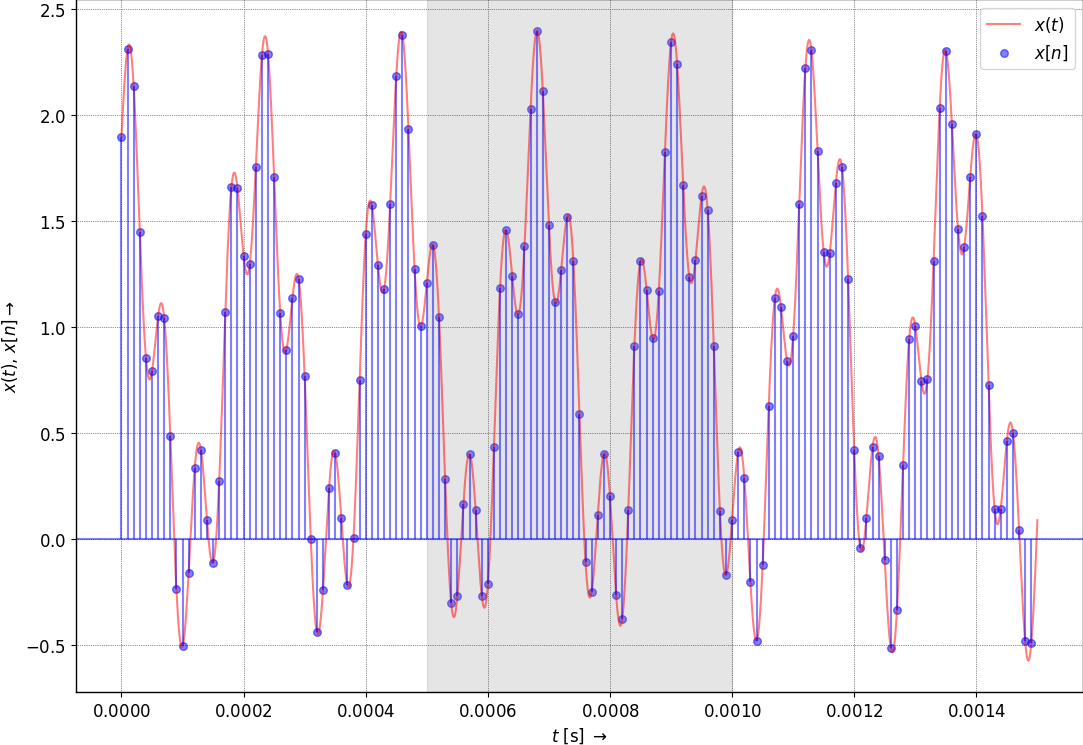

In [3]:
A_a = 1; f_a = Delta_f *  2.2     # Ton a, genau auf Auswertefrequenz
A_b = 0.5; f_b = Delta_f * 9.0  # Ton b, zwischen Auswertefrequenzen
DC = 0.9; sigma=0
print('f_a = ', f_a, 'Hz\t f_b = ', f_b, 'Hz')

def x(t): # Definiere Signalfunktion
    return DC + A_a * cos(2 * pi * t * f_a) + A_b * sin(2 * pi * t * f_b)\
            + sigma*np.random.randn(len(t))

xt = x(t) # x(t)
fig1, ax1 = plt.subplots(**figsize)
ax1.plot(t, xt, 'r', alpha=0.5, label=r"$x(t)$")
stems(n*T_S, x(n*T_S), ax=ax1, s=30, color='b', alpha=0.5, label=r"$x[n]$") #"abgetastetes" Signal
ax1.axvspan(t[N_FFT*OSR],t[(2*N_FFT)*OSR-1], alpha=0.2, color='grey') # plotte Fenster
ax1.set_xlabel(r'$t$ [s] $\rightarrow $');ax1.set_ylabel(r'$x(t),\, x[n] \rightarrow $'); ax1.legend();

# Nochmal!
Wir schneiden jetzt hart (Profis sagen mit einem "Rechteck-" oder "Boxcarfenster") $N_{FFT}$ Samples aus dem Signal $x[n]$ aus (grau hinterlegt) und erhalten die Folge $x_w[n]$. Zur Visualisierung ist die periodische Wiederholung von $x_w[n]$ grau gestrichelt geplottet. In der Realität hat man nur die Folge $x_w[n]$ mit $N_{FFT}$ Samples zur Verfügung.

Wir berechnen die DFT des gefensterten Signals über $N_{FFT}$ Samples, berechnen deren Absolutwert und skalieren die DFT mit dem Faktor $2/N_{FFT}$. Mit dieser Skalierung sind die Gesamtleistung im Frequenzbereich und im Zeitbereich identisch (Parcevalsche Beziehung).

Das Spektrum des "analogen" Signals $x(t)$ wird im folgenden Skript angenähert über eine DFT des ungefensterten Signals über $100 T_{meas}$, daraus resultiert eine Frequenzauflösung von $\Delta f = (100 T_{meas})^{-1}$. Eine Erhöhung der Abtastrate verbessert *nicht* die Frequenzauflösung, damit erhöht man nur die maximal darstellbare Frequenz. 

Die DTFT (unendlich viele Samples, die überall Null sind außerhalb des Fensters) tellt man auf ähnliche Weise dar, hier erhält man die Zwischenwerte mit Hilfe von Zeropadding vor der DFT. Die DTFT ist übrigens identisch mit der CFT des ausgeschnittenen analogen Signals (überall Null sind außerhalb des Fensters) sofern das Abtasttheorem eingehalten wurde.

Es wird das zweiseitige Spektrum dargestellt (mit Hilfe von fftshift(), siehe Notebooks zum 3. Kapitel), da bei einseitigen Spektra die Skalierung der DC-Wert nicht vernünftig skaliert werden kann: Die Halbierung der Amplitude von $X(f=0)$ so wie die Theorie es fordert, führt bei kontinuierlichen / "verschmierten" Spektra zu einem Sprung im Spektrum.

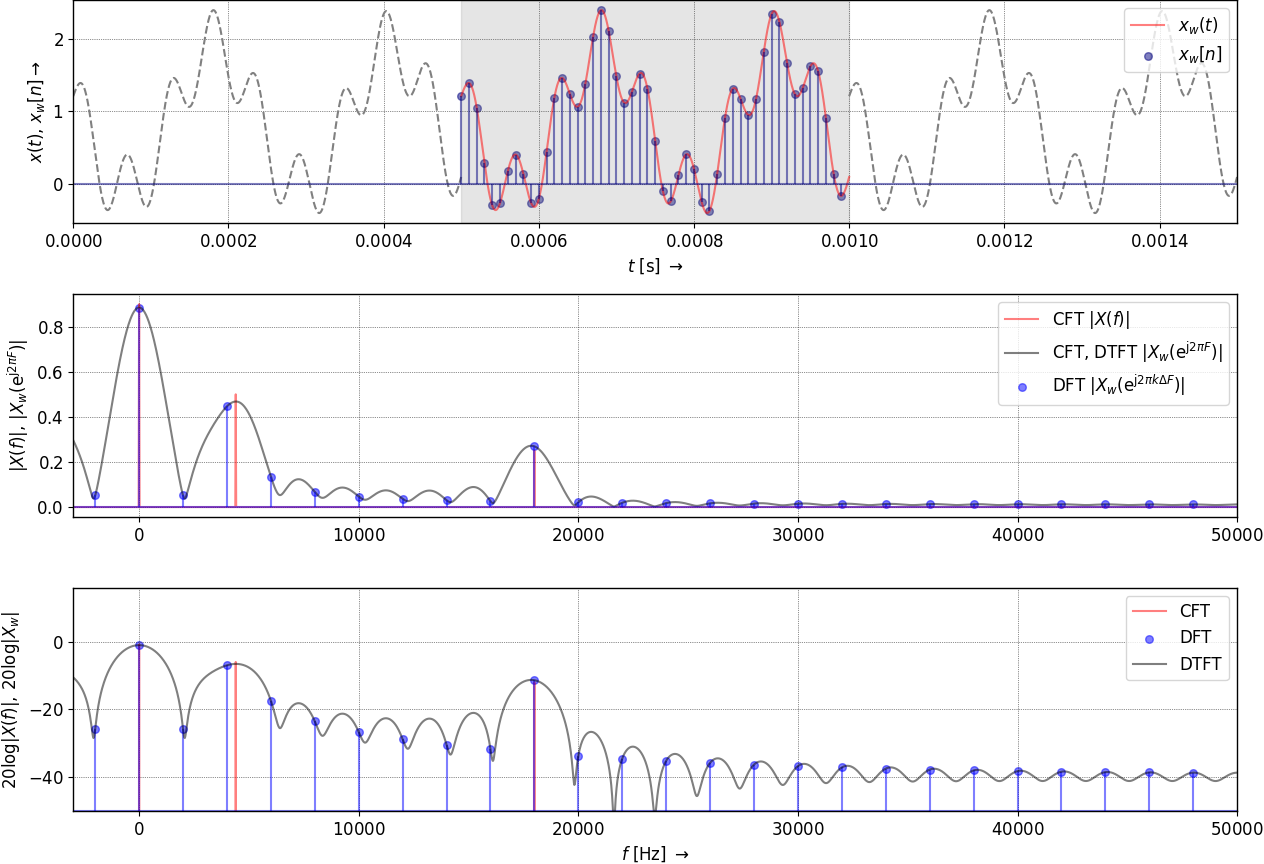

In [4]:
xtw = xt[N_FFT*OSR:2*N_FFT*OSR]  # Schneide das analoge Signal aus (Rechteckfenster)
xn = xtw[::OSR] # ... und taste es ab: Nimm nur jedes OSR'te Sample
#xtw = np.tile(xtw, L) # Wiederhole das analoge Signal L mal
tt = linspace(0,T_meas*100, N_FFT * 100, endpoint=False) # "analog" time for 100 windows giving a df = 1/(100T_meas)

fig2,ax2 = plt.subplots(nrows=3, ncols=1,**figsize)
ax2[0].plot(t[0:N_FFT*OSR], xtw, t[(2*N_FFT)*OSR:], xtw, color='grey', linestyle='--')
ax2[0].plot(t[N_FFT*OSR:(2*N_FFT)*OSR], xtw, 'r', alpha=0.5, label=r"$x_w(t)$")
stems(t[N_FFT*OSR:2*N_FFT*OSR:OSR],xn, ax=ax2[0], s=30, color=(0.0,0,0.5,0.5), label=r"$x_w[n]$") # x[n]
ax2[0].axvspan(t[N_FFT*OSR],t[(2*N_FFT)*OSR-1], alpha=0.2, color='grey') # markiere Fenster
ax2[0].set_xlabel(r'$t$ [s] $\rightarrow $');ax2[0].set_ylabel(r'$x(t),\, x_w[n] \rightarrow $'); ax2[0].legend(loc=1)
ax2[0].set_xlim(0, L*T_meas)
# ----- Spektrum ------
Xn = fftshift(np.abs(fft(xn, N_FFT)) / N_FFT)     # Berechne / skaliere für zweiseitiges Spektrum
Xt = fftshift(np.abs(fft(x(tt)))/len(tt))
XnDTFT = fftshift(np.abs(fft(xn[:N_FFT], len(tt)))/ N_FFT) # DFT von x_w[n] mit VIEL Zeropadding, gleiche Länge wie 
#Xn[0] = Xn[0] / 2                           # korrigiere DC-Wert
#Xt[0] = Xt[0] / 2   
f =  fftshift(fftfreq(len(Xn), T_S))                 # erzeuge N_FFT Freq.punkte bei [0... f_S/2[, [-f_S/2 ... f_s[]
fc = fftshift(fftfreq(len(Xt), T_S))
ax2[1].plot(fc, Xt, 'r', alpha=0.5, label=r"CFT $|X(f)|$")
ax2[1].plot(fc, XnDTFT, 'k', alpha=0.5, label=r"CFT, DTFT $|X_w(\mathrm{e}^{\mathrm{j} 2 \pi F})|$")
stems(f, Xn, ax=ax2[1], s=30, color='b', alpha=0.5, label=r"DFT $|X_w(\mathrm{e}^{\mathrm{j} 2 \pi k\Delta F})|$")

ax2[1].set_xlim(left=-0.03*f_S, right=f_S/2)
ax2[1].legend(loc='best'); ax2[1].set_ylabel(r'$|X(f)|, \,|X_w(\mathrm{e}^{\mathrm{j} 2 \pi F})|$')
# ----- log. Spektrum ------
ax2[2].plot(fc, 20*np.log10(Xt),'r', alpha=0.5, label=r"CFT")
stems(f, 20*np.log10(Xn), ax=ax2[2], s=30, bottom=-50, color='b', alpha=0.5, label=r"DFT")
ax2[2].plot(fc, 20*log10(XnDTFT), 'k', alpha=0.5, label=r"DTFT")
ax2[2].set_xlabel(r'$f$ [Hz] $\rightarrow $'); ax2[2].set_ylabel(r'$20 \log|X(f)|, \,20 \log|X_w|$')
ax2[2].set_xlim(ax2[1].get_xlim()); ax2[2].set_ylim(bottom=-50);ax2[2].legend(loc='best') 

fig2.tight_layout();

Je nach Wahl der Frequenzen wird das ausgeschnittene Fenster fehlerfrei wiederholt; in diesem Fall liegen Frequenz- und Amplitudenwerte der DFT (blaue Impulse) exakt auf dem Linienspektrum (rote Linien) der CFT.

Frequenzen, die nicht genau auf dem Raster $k\cdot \Delta f$ der FFT liegen, können durch die DFT nicht exakt wiedergegeben werden. In diesem Fall treten die folgenden Fehler auf:

* **Frequenzfehler:** Spektrallinien treten bei leicht verfälschten Frequenzen auf.
* **Amplitudenfehler:** Die Amplitude der Spektrallinie ist verfälscht. Dies nennt man auch "Lattenzauneffekt" (picket fence effect) weil es vergleichbar ist mit dem Blick auf ein Gebirge durch einen Lattenzaun: Bergspitzen erscheinen niedriger, Täler weniger tief. Eine andere Bezeichnung ist "scalloping loss", benannt nach der gewellten Kante einer Muschel. Die Bezeichnung bezieht sich auf den resultierenden welligen Frequenzgang.
* **Leckeffekt:** Auch bei Frequenzen, bei denen gar keine Spektralkomponenten zu finden sein sollten, ist die Amplitude jetzt ungleich Null. Aufgrund des Leckeffekts können schwache Signale komplett untergehen.

Um die Verringerung dieser Fehler wird es im nächsten **[Notebook](WIN-Basics_2.ipynb)** gehen.

## Fragen und Experimente
* Variieren Sie die Signalfrequenzen und schauen Sie sich die Effekte an, wenn Signale auf dem Frequenzraster bzw. dazwischen liegen.
* Setzen Sie $\sigma > 0$, um zu sehen, dass das Spektrum des analogen Signals (CFT) tatsächlich kontinuierlich ist und nicht nur aus diskreten Werten besteht wie das der DFT.
* Versuchen Sie ein Signal im "Schatten" des zweiten verschwinden zu lassen.
* Wie groß ist der maximale Amplitudenfehler des Rechteckfensters [ausprobieren]?
* Vollziehen Sie die Berechnung der FFT der "analogen" und abgetasteten Signale nach.

***
### Copyright

(c) 2016 - 2021 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2020*.